In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from sc import *
from plot import *
from tqdm import tqdm
from alg import  hstar, k_rollout, bhattacharya, almost_equal
from pqdict import pqdict

In [2]:
def alpha_sweep(SC, ref_path, alphas, max_depth, verbose=False, prune=False, eps=1e-4):
    paths = []
    data_arr = np.zeros((len(alphas), 4))
        
    for i, alpha in tqdm(enumerate(alphas)): 
        path_i, _, _, visited_i, time_i = k_rollout(SC, ref_path, alpha, max_depth, prune, eps, verbose, True)
        proj_diff_i, len_i= path_i.proj_diff(ref_path), path_i.weight
        data_arr[i,:] = proj_diff_i, len_i, visited_i, time_i
        paths.append(path_i)

    proj_diffs, path_lens, num_visited, times = data_arr[:,0], data_arr[:,1], data_arr[:,2], data_arr[:,3]

    return paths, path_lens, proj_diffs, num_visited, times

<AxesSubplot:>

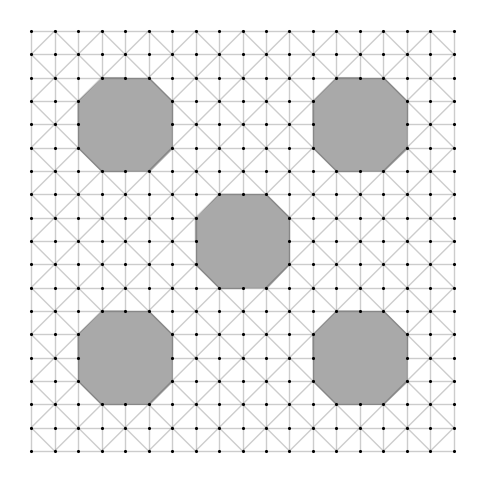

In [6]:
# Initialize Simplicial Complex (SC)
n = 19
SC = SimplicialComplex(n, False, False)
start, end = 0, len(SC.node_vec)-1

hole_locs = np.array([[-0.55, -0.55], [-0.55, 0.55], [0.55, 0.55], [0.55, -0.55]])
SC.make_holes(hole_locs, 0.2, np.inf)
SC.make_holes([[0,0]], 0.22, np.inf)
plot_sc(SC)


In [ ]:
coords = np.array([(-1,-1), (1,-1), (1, 0), (-1,0.3), (-1,1), (1,1)])
ref_path = path_from_coords(SC, coords)
plot_path(SC, ref_path, 'red', 'path')

In [4]:
alphas = np.linspace(0, 6, 30)
folder = "../exp2_data2"

In [ ]:
# Base heuristic 
paths_reg, path_lens_reg, proj_diffs_reg, num_visited_reg, times_reg = alpha_sweep(SC, ref_path, alphas, 0, False, False)
np.savez(f"{folder}/base",  paths=paths_reg, lengths=path_lens_reg, proj_diffs=proj_diffs_reg, num_visited=num_visited_reg, times=times_reg)

In [ ]:
# One step lookahead
paths_roll, path_lens_roll, proj_diffs_roll, num_visited_roll, times_roll = alpha_sweep(SC, ref_path, alphas, 1, False, False)
np.savez(f"{folder}/roll",  paths=paths_roll, lengths=path_lens_roll, proj_diffs=proj_diffs_roll, num_visited=num_visited_roll, times=times_roll)

In [ ]:
# One step lookahead w/ prune
paths_prune, path_lens_prune, proj_diffs_prune, num_visited_prune, times_prune = alpha_sweep(SC, ref_path, alphas, 1, False, True)
np.savez(f"{folder}/prune", paths=paths_prune, lengths=path_lens_prune, proj_diffs=proj_diffs_prune, num_visited=num_visited_prune, times=times_prune)

In [ ]:
# Bhattacharya
eps = 1e-7
start, end = ref_path[0], ref_path[-1]
path_bhat, other_paths_bhat, num_visited_bhat, time_bhat = bhattacharya(SC, ref_path, eps, True, False, True)
np.savez(f"{folder}/bhat",  path=path_bhat, others=other_paths_bhat, num_visited=num_visited_bhat, times=time_bhat)

In [ ]:
num_visited_bhat, time_bhat

# Process and plot 

In [7]:
data_reg = np.load(f"{folder}/base.npz", allow_pickle=True)
paths_reg, path_lens_reg, proj_diffs_reg, num_visited_reg, time_reg = data_reg["paths"], data_reg["lengths"], data_reg["proj_diffs"], data_reg["num_visited"], data_reg["times"]
data_roll = np.load(f"{folder}/roll.npz", allow_pickle=True)
paths_roll, path_lens_roll, proj_diffs_roll, num_visited_roll, time_roll = data_roll["paths"], data_roll["lengths"], data_roll["proj_diffs"], data_roll["num_visited"], data_roll["times"]
data_prune = np.load(f"{folder}/prune.npz", allow_pickle=True)
paths_prune, path_lens_prune, proj_diffs_prune, num_visited_prune, time_prune = data_prune["paths"], data_prune["lengths"], data_prune["proj_diffs"], data_prune["num_visited"], data_prune["times"]
data_bhat = np.load(f"{folder}/bhat.npz", allow_pickle=True)
path_bhat, other_paths_bhat, num_visited_bhat, time_bhat = Path(SC, data_bhat["path"]), data_bhat["others"], data_bhat["num_visited"], data_bhat["times"]

In [12]:
np.sum(SC.node_vec)

316

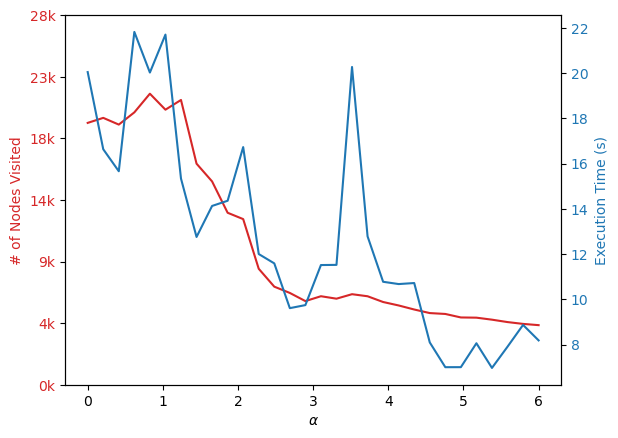

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('# of Nodes Visited', color=color)
ax1.plot(alphas, num_visited_prune, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Execution Time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, time_prune, color=color)
ax2.tick_params(axis='y', labelcolor=color)

y3ticks = np.round(np.linspace(0, 28000, 7))
ax1.set_yticks(y3ticks)
ax1.set_yticklabels([str(int(i/1000))+"k" for i in y3ticks]) #, fontdict=font)

plt.show()

In [ ]:
def get_transitions(path_arr, ref_proj):
    proj_arr = np.array([np.linalg.norm(x.proj - ref_proj, 2) for x in path_arr])
    proj_grad = proj_arr[:-1] - proj_arr[1:]
    transitions = np.where(proj_grad > 0)[0] + 1
    return np.append([0], transitions)

def identify_class(heuristic_paths, bhat_paths, eps=1e-5):
    corresponding_shortest = []
    for i, path_i in enumerate(heuristic_paths):
        for j, path_j in enumerate(bhat_paths):
            if almost_equal(path_i.proj, path_j.proj, eps):
                corresponding_shortest.append(path_j)
                break
    return corresponding_shortest

ref_proj = ref_path.proj

trans_reg = get_transitions(paths_reg, ref_proj)
trans_roll = get_transitions(paths_roll, ref_proj)
trans_prune = get_transitions(paths_prune, ref_proj)

def get_best_paths(paths, bounds):
    best_paths = []
    path_lens = [x.weight for x in paths]
    for i in range(len(bounds)):
        left = bounds[i]
        right = len(paths) if i == len(bounds) - 1 else bounds[i+1]
        sub_arr = path_lens[left:right]
        best_path = paths[left + np.argmin(sub_arr)]
        best_paths.append(best_path)

    return best_paths

def assign_colors_to_paths(paths1, paths2, paths3, colors, decimals):
    paths = paths1 + paths2 + paths3
    color_dict = {}
    k = 1
    assigned_colors = [None] * len(paths)
    for i, x in enumerate(paths):
        proj_x = tuple(np.round(x.proj, decimals))
        if proj_x in color_dict:
            assigned_colors[i] = color_dict[proj_x]
        if proj_x not in color_dict:
            k += 1
            color_dict[proj_x] = colors[k]
            assigned_colors[i] = colors[k]

    n1, n2, n3 = len(paths1), len(paths2), len(paths3)

    path1_colors = colors[:2] + assigned_colors[:n1]
    path2_colors = colors[:2] + assigned_colors[n1:n1+n2]
    path3_colors = colors[:2] + assigned_colors[n1+n2:]

    return path1_colors, path2_colors, path3_colors, color_dict

paths_to_plot_reg = get_best_paths(paths_reg, trans_reg)
paths_to_plot_roll = get_best_paths(paths_roll, trans_roll)
paths_to_plot_prune = get_best_paths(paths_prune, trans_prune)

decimals=3
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#984ea3', '#f781bf', '#a65628',
                  '#999999', '#e41a1c', '#dede00']

colors_reg, colors_roll, colors_prune, color_dict = assign_colors_to_paths(paths_to_plot_reg, paths_to_plot_roll, paths_to_plot_prune, colors, decimals)


In [ ]:
font = {'family': 'Helvetica',
    'color':  'black',
    'weight': 'normal',
    'size': 24}

matplotlib.style.use('ggplot')
plt.rcParams['text.usetex'] = False
plt.figure(0, (16, 4))
fig, axes = plt.subplots(1, 3, figsize=(26,6))

ax1 = plt.subplot(131)
ax1.axhline(path_bhat.weight, color=colors[1], linestyle='dashed', linewidth=4, alpha=0.5, label="Bhattacharya et al")
# for i, path in enumerate(list(other_paths_bhat) + [path_bhat]):
#     for x in list(paths_reg) + list(paths_roll) + list(paths_prune):
#         proj_comp = x.proj_diff(path, False)        
#         if proj_comp == 0:
#             ax1.axhline(path.weight, color='k', linestyle=(0, (1, 10)), alpha=0.7)
#             break
ax1.plot(alphas, path_lens_reg, label="H*", color=colors[2], linewidth=2.5)
ax1.plot(alphas, path_lens_roll, label="RH*", color=colors[3], linewidth=2.5)
ax1.plot(alphas, path_lens_prune, label="PRH*", color=colors[4], linewidth=2.5)
# ax1.legend(loc='upper left', fontsize=16)
ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_ylabel(r"$W(\tau)$", fontdict=font)

ax2 = plt.subplot(132)
ax2.axhline(0, color=colors[1], linestyle='dashed', linewidth=4, alpha=0.5, label="Bhattacharya et al")
# for path in list(other_paths_bhat) + [path_bhat]:
#     for x in list(paths_reg) + list(paths_roll) + list(paths_prune):
#         proj_comp = path.proj_diff(x, False)
#         if proj_comp == 0:
#             proj_diff = path.proj_diff(ref_path, False)
#             ax2.axhline(proj_diff, color='k', linestyle=(0, (1, 7)), alpha=0.7)
#             break
# ax2.axvline(1.171052335161985, color='k', linestyle=':', alpha=0.2)
ax2.plot(alphas, proj_diffs_reg, label="H*", color=colors[2], linewidth=2.5)
ax2.plot(alphas, proj_diffs_roll, label="RH*", color=colors[3], linewidth=2.5)
ax2.plot(alphas, proj_diffs_prune, label="PRH*", color=colors[4], linewidth=2.5)
# ax2.legend(loc='upper left', fontsize=16)
ax2.set_xlabel(r"$\alpha$", fontdict=font)
ax2.set_ylabel(r"$\Delta \gamma(\tau, \bar{\tau})$", fontdict=font)

ax3 = plt.subplot(133)
plt.axhline(num_visited_bhat, color=colors[1], linestyle='dashed', linewidth=4, alpha=0.5, label="Bhattacharya et al")
plt.plot(alphas, num_visited_reg, label="H*", color=colors[2], linewidth=2.5)
plt.plot(alphas, num_visited_roll, label="RH*", color=colors[3], linewidth=2.5)
plt.plot(alphas, num_visited_prune, label="PRH*", color=colors[4], linewidth=2.5)
# ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel(r"Number of nodes visited", fontdict=font)

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)

xticks = np.round(np.linspace(0,alphas[-1], 7), 2)
y1ticks = np.round(np.linspace(3, 6.5, 7), 2)
y2ticks = np.round(np.linspace(0, 3, 7), 2)
y3ticks = np.round(np.linspace(0, 30000, 7))

ax1.set_xticks(xticks)
ax1.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax1.set_yticks(y1ticks)
ax1.set_yticklabels([str(i) for i in y1ticks], fontdict=font)

ax2.set_xticks(xticks)
ax2.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax2.set_yticks(y2ticks)
ax2.set_yticklabels([str(np.round(i, 1)) for i in y2ticks], fontdict=font)

ax3.set_xticks(xticks)
ax3.set_xticklabels([str(i) for i in xticks], fontdict=font)

ax3.set_yticks(y3ticks)
ax3.set_yticklabels([str(int(i/1000))+"k" for i in y3ticks], fontdict=font)

plt.savefig(f"{folder}/exp2_alpha_sweep_alt.png", dpi=300, bbox_inches='tight', format='png', pad_inches=0)

In [ ]:
np.mean(times_reg / num_visited_reg), np.std(times_reg / num_visited_reg)

In [ ]:
np.mean(times_roll / num_visited_roll), np.std(times_roll / num_visited_roll)

In [ ]:
np.mean(times_prune / num_visited_prune), np.std(times_prune / num_visited_prune)

In [ ]:
print(np.mean(time_bhat / num_visited_bhat), np.std(time_bhat / num_visited_bhat))